# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [21]:
folder_with_data = './../assignment1/data/'

# First, lets load the dataset
data_train = dset.SVHN(folder_with_data, split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN(folder_with_data, split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [8]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [9]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [10]:
nn_model = nn.Sequential(Flattener(),
                         nn.Linear(3*32*32, 100),
                         nn.ReLU(inplace=True),
                         nn.Linear(100, 10))
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [11]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs): 
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = nn_model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    val_accuracy = 0
    correct = 0
    total = 0
    for i_step, (x, y) in enumerate(loader):
        pred = nn_model(x)
        
        _, indices = torch.max(pred, 1)
        correct += torch.sum(indices == y)
        total += y.shape[0]
        
        val_accuracy = float(correct)/total
    
    return val_accuracy

In [12]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 4)

Average loss: 1.845676, Train accuracy: 0.406597, Val accuracy: 0.551839
Average loss: 1.462106, Train accuracy: 0.580640, Val accuracy: 0.596546
Average loss: 1.385530, Train accuracy: 0.613794, Val accuracy: 0.630059
Average loss: 1.355179, Train accuracy: 0.631539, Val accuracy: 0.647464


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [13]:
# Since it's so easy to add layers, let's add some!

nn_model = nn.Sequential(Flattener(),
                         nn.Linear(3*32*32, 100),
                         nn.ReLU(inplace=True),
                         nn.Linear(100, 100),
                         nn.ReLU(inplace=True),
                         nn.Linear(100, 10))
nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=2e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader,loss, optimizer, 10)

Average loss: 2.087602, Train accuracy: 0.239617, Val accuracy: 0.352399
Average loss: 1.754933, Train accuracy: 0.404924, Val accuracy: 0.403112
Average loss: 1.694943, Train accuracy: 0.430570, Val accuracy: 0.423930
Average loss: 1.685758, Train accuracy: 0.438488, Val accuracy: 0.439014
Average loss: 1.675261, Train accuracy: 0.441917, Val accuracy: 0.448024
Average loss: 1.668152, Train accuracy: 0.444972, Val accuracy: 0.432462
Average loss: 1.665084, Train accuracy: 0.445620, Val accuracy: 0.445976
Average loss: 1.668234, Train accuracy: 0.447224, Val accuracy: 0.448911
Average loss: 1.664967, Train accuracy: 0.445074, Val accuracy: 0.452051
Average loss: 1.666716, Train accuracy: 0.446371, Val accuracy: 0.450208


Добавьте слой с Batch Normalization

In [14]:
# We heard batch normalization is powerful, let's use it!

nn_model = nn.Sequential(Flattener(),
                         nn.Linear(3*32*32, 100),
                         nn.BatchNorm1d(100),
                         nn.ReLU(inplace = True),
                         nn.Linear(100, 100),
                         nn.BatchNorm1d(100),
                         nn.ReLU(inplace = True),
                         nn.Linear(100, 10))

nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=2e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader,loss, optimizer, 10)

Average loss: 1.792402, Train accuracy: 0.447667, Val accuracy: 0.481196
Average loss: 1.782654, Train accuracy: 0.464423, Val accuracy: 0.425227
Average loss: 1.830976, Train accuracy: 0.428659, Val accuracy: 0.431711
Average loss: 1.839380, Train accuracy: 0.419428, Val accuracy: 0.383728
Average loss: 1.848844, Train accuracy: 0.414309, Val accuracy: 0.418197
Average loss: 1.851723, Train accuracy: 0.411869, Val accuracy: 0.339772
Average loss: 1.857984, Train accuracy: 0.407467, Val accuracy: 0.392738
Average loss: 1.859148, Train accuracy: 0.405573, Val accuracy: 0.385707
Average loss: 1.861857, Train accuracy: 0.405385, Val accuracy: 0.406935
Average loss: 1.864063, Train accuracy: 0.404242, Val accuracy: 0.428708


Добавьте уменьшение скорости обучения по ходу тренировки.

In [15]:
def train_model_parametrized(model, train_loader, val_loader, 
                             loss, optimizer, num_epochs, 
                             step_size_shed, gam_shed): 
    sheduler = optim.lr_scheduler.StepLR(optimizer, step_size = step_size_shed, gamma = gam_shed)
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        sheduler.step()
        for i_step, (x, y) in enumerate(train_loader):
            prediction = nn_model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [16]:
# Learing rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(Flattener(),
                          nn.Linear(3*32*32, 100),
                          nn.BatchNorm1d(100),
                          nn.ReLU(inplace = True),
                          nn.Linear(100, 100),
                          nn.BatchNorm1d(100),
                          nn.ReLU(inplace = True),
                          nn.Linear(100, 10))

nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=2e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model_parametrized(nn_model, train_loader, val_loader,loss, 
                                                                    optimizer, 15, 2, 0.5)

d:\program files\python37\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Average loss: 1.793981, Train accuracy: 0.449254, Val accuracy: 0.476418
Average loss: 1.703588, Train accuracy: 0.522745, Val accuracy: 0.513549
Average loss: 1.726390, Train accuracy: 0.499863, Val accuracy: 0.461607
Average loss: 1.681574, Train accuracy: 0.522643, Val accuracy: 0.518326
Average loss: 1.673630, Train accuracy: 0.521056, Val accuracy: 0.537847
Average loss: 1.627494, Train accuracy: 0.547538, Val accuracy: 0.557505
Average loss: 1.619368, Train accuracy: 0.549295, Val accuracy: 0.564808
Average loss: 1.585005, Train accuracy: 0.570829, Val accuracy: 0.583237
Average loss: 1.578237, Train accuracy: 0.574003, Val accuracy: 0.580097
Average loss: 1.554909, Train accuracy: 0.588063, Val accuracy: 0.593202
Average loss: 1.549618, Train accuracy: 0.589940, Val accuracy: 0.596615
Average loss: 1.536564, Train accuracy: 0.597993, Val accuracy: 0.606785
Average loss: 1.533270, Train accuracy: 0.599956, Val accuracy: 0.608491
Average loss: 1.525472, Train accuracy: 0.605058, V

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [17]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    loader = torch.utils.data.DataLoader(dataset, 
                                           sampler=SubsetSampler(indices))
    predictions = []
    ground_truth = []
    for i_step, (x, y) in enumerate(loader):
        pred = model(x)
        _, indices = torch.max(pred, 1)
        predictions.append(int(indices))
        ground_truth.append(int(y))
    
    return np.array(predictions), np.array(ground_truth)

# Evaluate model on validation

predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

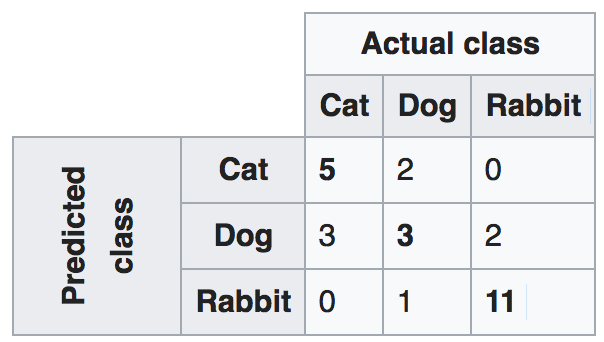

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

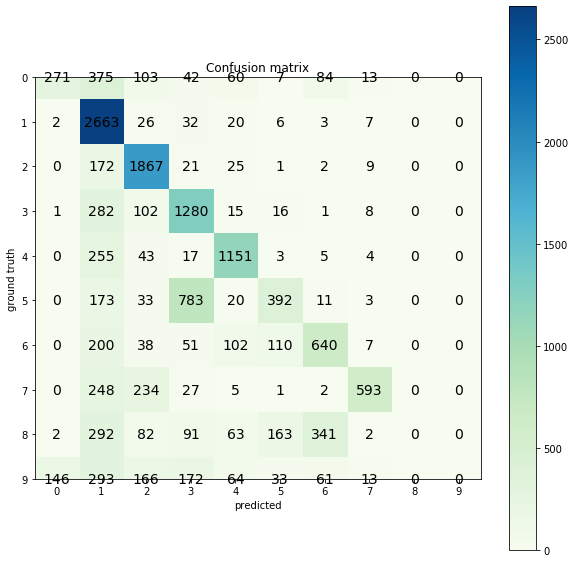

In [18]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.xlabel("predicted")
    plt.ylabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    for i in range(len(predictions)):
        confusion_matrix[ground_truth[i]][predictions[i]] += 1
    
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Очень плохо определяем нули :(

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

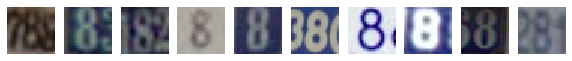

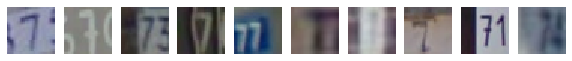

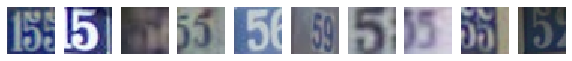

In [22]:
data_train_images = dset.SVHN(folder_with_data, split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    visualize_images(val_indices[np.logical_and(predictions == predicted_class, ground_truth == gt_class)], data)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(3, 5, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на валидацонной выборке должна быть доведена до **60%**

За лучший результат в группе вы получите дополнительные баллы :)

In [27]:
lr_rates = [1e-4, 1e-3]
weight_decays = [1e-5, 1e-4]
neurons_nums = [100, 200]

num_epochs = 5 # Set minimum epochs
best_nn = (0,0)
best_val = -1

for neurons in neurons_nums:
    for wd in weight_decays:
        for lr in lr_rates:
            print(f'Parameters are lr={lr}, neurons={neurons}')
            nn_model = nn.Sequential(Flattener(),
                                     nn.Linear(3*32*32, neurons),
                                     nn.BatchNorm1d(neurons),
                                     nn.ReLU(inplace = True),
                                     nn.Linear(neurons, neurons),
                                     nn.BatchNorm1d(neurons),
                                     nn.ReLU(inplace = True),
                                     nn.Linear(neurons, 10))
            nn_model.type(torch.FloatTensor)
            optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=wd)
            loss_history, train_history, val_history = train_model_parametrized(
                                    nn_model, train_loader, val_loader,loss, 
                                    optimizer, num_epochs, 2, 0.5)
            if best_val < val_history[len(val_history)-1]:
                best_val = val_history[len(val_history)-1]
                best_nn = (nn_model, optimizer)

Parameters are lr=0.0001, neurons=100
Average loss: 1.589646, Train accuracy: 0.528018, Val accuracy: 0.658726
Average loss: 1.104663, Train accuracy: 0.690714, Val accuracy: 0.722681
Average loss: 0.965734, Train accuracy: 0.722486, Val accuracy: 0.739949
Average loss: 0.863650, Train accuracy: 0.749838, Val accuracy: 0.761586
Average loss: 0.819137, Train accuracy: 0.762345, Val accuracy: 0.772097
Parameters are lr=0.001, neurons=100
Average loss: 1.337845, Train accuracy: 0.568133, Val accuracy: 0.673060
Average loss: 0.895345, Train accuracy: 0.724294, Val accuracy: 0.757696
Average loss: 0.802787, Train accuracy: 0.751118, Val accuracy: 0.779196
Average loss: 0.699520, Train accuracy: 0.783520, Val accuracy: 0.794553
Average loss: 0.659848, Train accuracy: 0.796403, Val accuracy: 0.802676
Parameters are lr=0.0001, neurons=100
Average loss: 1.602354, Train accuracy: 0.519179, Val accuracy: 0.675381
Average loss: 1.099020, Train accuracy: 0.692779, Val accuracy: 0.727595
Average los

In [28]:
print()
print(f'Best accuracy is {best_val}')


Best accuracy is 0.8253361545287011


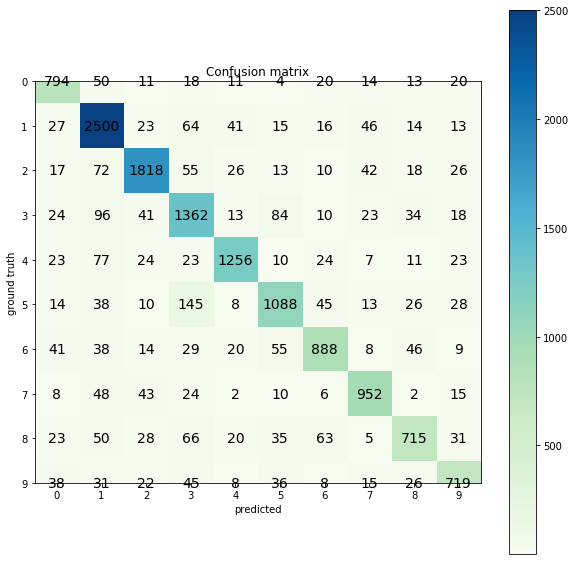

In [29]:
predictions, gt = evaluate_model(best_nn[0], data_train, val_indices)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

In [30]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(best_nn[0], test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8020
